   # Extending Single Domain Approach: the effect of interactions

## Here it will be implemented 'my approach' to include interactions in the free energy density within the Stoner-Wohlfarth (single-domain) framework. It will be addressed magnetic interactions, such as dipole-dipole, exchange and dzyaloshinskii-moriya to calculate magnetization curves. Basically, for a given particle 'j' of the array in the step 'k' of the hysteresis procedure, the magnetization value ( described by $(\theta_j,\phi_j)$) of its neighbors will be approximated by its value in the step 'k-1'th (previous computation of the magnetic moments orientation). In this way, starting from technical saturation at high fields, the magnetization angles of the whole array can be calculated through common energy minimization procedures. The approach succeeds when the field-step is small enough to assure convergence of the calculations.

# In this notebook it will be investigated the influence of interactions for Shape Memory Alloys.
# The phenomenology developed in the manuscript of the rolled-up nanomembranes of Ni2MnGa will be used.
# The interesting case is to investigate the dipolar interaction influence in the magnetic hysteresis loops of Ni2MnGa nanomembranes.

In [7]:
# the necessary import statements!

# to paralelize and accelerate the calculations
import numba as nb
from numba import jit
from numba import njit


import joblib
from joblib import Parallel, delayed
import multiprocessing


# numpy for fast calculations using arrays
import numpy as np

# scipy for minimization
import scipy
from scipy import optimize
from scipy.optimize import minimize as spmin
from scipy.optimize import Bounds

# some trigonometric functions
from math import pi, sin, cos, sqrt
import math

# to plot graphics
import matplotlib.pyplot as plt
%matplotlib inline

# the time of some calculations
import timeit

import dlib

import random


In [8]:
# trying to use compiled functions from scipy with numba!

#from numba import numba_scipy

In [9]:
# parameters of the simulation

Msat=float(1000)
Ms=float(1/1000)

K1=float(((-1*3.15)*10**6))
K2=float((-0*1.0*10**5))
Kuni=float((0*1.0*10**6))
Kuni2=float((0*0.2*10**2))
K1mel=float((1*4.0*10**6))
Neff=float(0*1.000)
#field-dependent anisotropy
Kfd=float(-0*0.30*10**0)
#Krot=float((1*2.50*10**4))
Krot=float((0*4.50*10**3))
Krot2=float((-0*1.80*10**3))
htheta=float(+1*pi/2.)
hphi=float(1*pi/4+0*pi/180.)

# Nanoparticle arrangement order
# 1-> square
# 2-> ring
# 3-> nanomembrane
np_order = 3


Nparticles=5

height=20

NN=Nparticles**3
NN2=Nparticles**2

# interaction strengths!

beta = 1*1.30

jota = -1.0


In [10]:
print(beta)

1.3


In [11]:
# applied field parameters

hini=-10400.*3
hfinal=10400.*3
step=600*2
stepmag=0.15/step
stepmag=0.00/step
hpasso=(hfinal-hini)/step
print(K1,K2,Krot,Msat,step)

-3150000.0 0.0 0.0 1000.0 1200


In [12]:
# array for angle dispersion in 'phi' and 'theta'

phi_np = np.array([0*random.random() for x in range(NN2)],dtype=np.float64)
theta_np = np.array([0*random.random() for x in range(NN2)],dtype=np.float64)
#print(phi_np)

In [13]:
# the function that defines the common magnetic anisotropy terms
#@jit(nopython=True)
@jit(nopython=True,parallel=True)
def anisotropy(phi,theta,K1,K2,h,htheta,hphi,Msat,i):

# first-order cubic magnetocrystalline anisotropy
    anis=K1/(Msat**2)*(np.sin(phi-phi_np[i])**2*np.cos(phi-phi_np[i])**2*np.sin(theta-theta_np[i])**4+np.sin(phi-phi_np[i])**2*np.sin(theta-theta_np[i])**2*np.cos(theta-theta_np[i])**2+np.cos(phi-phi_np[i])**2*np.sin(theta-theta_np[i])**2*np.cos(theta-theta_np[i])**2)

# second-order cubic magnetocrystalline anisotropy    
    anis+=K2/(Msat**2)*np.sin(phi)**2*np.sin(theta)**2*np.cos(phi)**2*np.sin(theta)**2*np.cos(theta)**2

# demagnetizing energy
    anis+=2*3.1415*Neff*np.cos(theta)**2

# magelas anisotropy 
    
    anis+=K1mel/(Msat**2)*np.cos(phi-phi_np[i])**2*np.sin(theta-theta_np[i])**2
    
    
# uniaxial anisotropy 
    
    anis+=Kuni/(Msat**2)*np.sin(phi-3.1415/4.)**2*np.sin(theta-3.1415/4.)**2
    
# uniaxial anisotropy 
    
    anis+=Kuni2/(Msat**2)*np.sin(phi-3.1415/4.)**4*np.sin(theta-3.1415/4.)**4

# field dependent anis!

#    anis+=Kfd/(Msat**2)*h*Msat*(np.sin(htheta)*np.sin(theta)*np.cos(phi-hphi)+np.cos(htheta)*np.cos(theta))
    anis+=Kfd/(Msat**2)*h*Msat**2*(np.sin(theta)*np.cos(phi-3.1415/4.))**2
    
# rotatable anis!

#    anis+=Krot/(Msat**2)*(h*Msat)**1*(np.sin(htheta)*np.sin(theta)*np.cos(phi-hphi)+np.cos(htheta)*np.cos(theta))**1
#    anis+=Krot/(Msat**2)*(np.sin(htheta)*np.sin(theta-theta_np[i])*np.cos(phi-phi_np[i]-hphi)+np.cos(htheta)*np.cos(theta-theta_np[i]))**2
    anis+=Krot/(Msat**2)*(np.sin(htheta)*np.sin(theta)*np.cos(phi-hphi)+np.cos(htheta)*np.cos(theta))**2

    anis+=Krot2/(Msat**2)*(np.sin(htheta)*np.sin(theta)*np.cos(phi-hphi)+np.cos(htheta)*np.cos(theta))**4
    
    
    return anis
    

In [14]:
# Zeeman Energy

#@jit(nopython=True)
@jit(nopython=True,parallel=True)
def zeeman_energy(phi,theta,K1,K2,h,htheta,hphi,Msat,i):
    
    zeeman=-h*(np.sin(htheta)*np.sin(theta)*np.cos(phi-hphi)+np.cos(htheta)*np.cos(theta))


    return zeeman


In [15]:
# creating positions!
# this is for creating positions!

#@jit(nopython=True,parallel=True)
#@jit(nopython=True)
def create_pos(np_order,NN2):
    
    if(np_order==1):
        
        nnx=int(sqrt(NN2))
        nny=int(sqrt(NN2))
        
        coord_pos = []
#        coord_pos = np.zeros((nnx,nny,nnx))
#        coord_pos = np.zeros(NN2)
        
        for i in range(nnx):

            for j in range(nnx):
                
#                coord_pos.append([i,j,0])
                coord_pos.append([1*i,1*j,0])
#                coord_pos = np.append(coord_pos,[1*i,1*j,0])

#                coord_pos[i][j][0] = np.array([1*i,1*j,0])
    
    elif(np_order==2):
        
        coord_pos=[]
        
        for i in range(NN2):
            
            coord_pos.append([NN2*math.cos(2*pi*i/NN2),NN2*math.sin(2*pi*i/NN2),0])
    
    elif(np_order==3):
        
        coord_pos=[]
        
        for j in range(height):
        
            for i in range(NN2):

                coord_pos.append([NN2*math.cos(2*pi*i/NN2),j,NN2*math.sin(2*pi*i/NN2)])

    return np.array(coord_pos,dtype=np.float64)


In [16]:
# this is to create the angles, which are used in the computation of the interactions!

ar_pos=create_pos(np_order,NN2)


#@jit(nopython=True,parallel=True)
@jit(nopython=True)
def angles_vecs(NN2):

    print(np_order)
#    ar_pos=create_pos(np_order,NN2)

#    print(ar_pos)
    
    x_coord = [ar_pos[i][0] for i in range(NN2*height)]
    y_coord = [ar_pos[i][1] for i in range(NN2*height)]
    z_coord = [ar_pos[i][2] for i in range(NN2*height)]

    x_ang = []
    y_ang = []
    
    for i in range(NN2*height):
        x_ang_menor=[]
        y_ang_menor=[]
        
        for j in range(NN2*height):
            
            if(i!=j):
                innerproduct = x_coord[i]*x_coord[j]+y_coord[i]*y_coord[j]

                dist1 = sqrt(x_coord[i]**2+y_coord[i]**2+z_coord[i]**2)
                dist2 = sqrt(x_coord[j]**2+y_coord[j]**2+z_coord[j]**2)
                
                distnewvec = sqrt((x_coord[j]-x_coord[i])**2+(y_coord[j]-y_coord[i])**2+(z_coord[j]-z_coord[i])**2)
                distnewvecplane = sqrt((x_coord[j]-x_coord[i])**2+(y_coord[j]-y_coord[i])**2)
                
                if(distnewvecplane!=0.0):
#                    angphi = math.acos((x_coord[j]-x_coord[i])/distnewvecplane)
#                    angtheta = math.acos((z_coord[j]-z_coord[i])/distnewvec)
                    angphi = math.acos((x_coord[i]-x_coord[j])/distnewvecplane)
                    angtheta = math.acos((z_coord[i]-z_coord[j])/distnewvec)
                elif(distnewvecplane == 0.0):
                    angphi = 0.0
                    angtheta = 3.1415/2.
                x_ang_menor.append(angphi)
                y_ang_menor.append(angtheta)
                
            elif(i==j):
                
                x_ang_menor.append(0.0)
                y_ang_menor.append(0.0)
                
        x_ang.append(x_ang_menor)
        y_ang.append(y_ang_menor)
        x_ang_menor=[]
        y_ang_menor=[]
                

                
#    return np.array(x_ang,dtype=np.float64),np.array(y_ang,np.float64)
#    return np.array(x_ang),np.array(y_ang)
    return x_ang,y_ang

In [17]:
# Function to calculate the distance between particles 'i' and 'j'

#@jit(nopython=True)
def dist_dipolar(i,j):
    sizex=int(sqrt(NN2))
    sizey=int(sqrt(NN2))
    
    # distance of particle 'j' from particle 'i'
#    distdip=[]
    '''
    for ii in range(sizex):
        for jj in range(sizey):
            distdip.append(sqrt((int(i/sizex)-ii)**2+(int(i%sizey)-jj)**2))
    '''
    
    '''
    distdip=sqrt((int(i/sizex)-int(j/sizex))**2+(int(i%sizey)-int(j%sizey))**2)
    '''

    if(np_order==1):

        distdip=[]
        for ii in range(NN2):
            distdip1=[]
            for jj in range(NN2):
                distdip1.append(sqrt((int(ii/sizex)-int(jj/sizex))**2+(int(ii%sizey)-int(jj%sizey))**2))
            distdip.append(distdip1)
            
    elif(np_order==2):
        
        distdip=[]
#        distdip=np.empty(NN2)
        for ii in range(NN2):
            distmin=[]
            distdip1=[]
            for jj in range(NN2):
                distdip1.append(sqrt((math.cos(2*pi*ii/NN2)-math.cos(2*pi*jj/NN2))**2+(math.sin(2*pi*ii/NN2)-math.sin(2*pi*jj/NN2))**2))
            
                if(ii!=jj):
                    distmin.append(sqrt((math.cos(2*pi*ii/NN2)-math.cos(2*pi*jj/NN2))**2+(math.sin(2*pi*ii/NN2)-math.sin(2*pi*jj/NN2))**2))

            arraydistmin=np.array(distmin)
            
            distdip1new=[]
            
            for u in range(NN2):
                distdip1new.append(distdip1[u]/np.amin(arraydistmin))
            
            distdip.append(distdip1new)
#            distdip1=np.array(distdip1)
#            distmin=np.array(distmin)
#            distdip[ii]=distdip1/np.amin(distmin)
#            distdip=np.array(distdip)


    elif(np_order==3):
        
        distdip=[]
#        distdip=np.empty(NN2)
        for ii in range(NN2*height):
            distmin=[]
            distdip1=[]
            for jj in range(NN2*height):
#                for kkk in range(height):
#                    for kk in range(height):
           
                distdip1.append(sqrt((math.cos(2*pi*(ii%NN2)/NN2)-math.cos(2*pi*(jj%NN2)/NN2))**2+(math.sin(2*pi*(ii%NN2)/NN2)-math.sin(2*pi*(jj%NN2)/NN2))**2+((int(ii/NN2)-int(jj/NN2))/height)**2))

                if(ii!=jj):
                
                    distmin.append(sqrt((math.cos(2*pi*(ii%NN2)/NN2)-math.cos(2*pi*(jj%NN2)/NN2))**2+(math.sin(2*pi*(ii%NN2)/NN2)-math.sin(2*pi*(jj%NN2)/NN2))**2+((int(ii/NN2)-int(jj/NN2))/height)**2))

            arraydistmin=np.array(distmin)

            distdip1new=[]
            if(np.amin(arraydistmin)==0.0):
                print(ii,'ii')
                print(distdip1[1])
                print('zerou',np.argmin(arraydistmin),arraydistmin[np.argmin(arraydistmin)-1])
                break

            for u in range(NN2*height):
                distdip1new.append(distdip1[u]/np.amin(arraydistmin))

            distdip.append(distdip1new)



#        distdip=[]
        
#    return np.array(distdip,dtype=np.float64)
#    return distdip[j]
    return distdip


In [18]:
ii=20
jj=30
print(len(dist_dipolar(2,3)))
dist_dipolar(20,30)[4][4+16]

500


36.19308209864078

In [19]:
sqrt((10%height/height)**2)
(((0%height)-(int(320/height)))/height)**2

0.6400000000000001

In [20]:
math.cos(2*pi*(64%NN2)/NN2)

-0.9297764858882515

In [21]:
dd=np.zeros((9),dtype=np.object)
print(dd[2])
dd[1]=np.array((1,2))
print(dd)

0
[0 array([1, 2]) 0 0 0 0 0 0 0]


In [18]:
print(10%int(sqrt(NN2)),10/int(sqrt(NN2)))
print(int(sqrt(NN2)))

0 2.0
5


In [22]:
vec_dip=np.array(dist_dipolar(20,30))

In [23]:
vec_dip[1]

array([ 5.01332934,  0.        ,  5.01332934,  9.94759549, 14.72498211,
       19.27014696, 23.51141009, 27.38188424, 30.82052971, 33.77311702,
       36.1930821 , 38.04226065, 39.29149003, 39.92106914, 39.92106914,
       39.29149003, 38.04226065, 36.1930821 , 33.77311702, 30.82052971,
       27.38188424, 23.51141009, 19.27014696, 14.72498211,  9.94759549,
        5.11209068,  1.        ,  5.11209068,  9.99773254, 14.75889894,
       19.29607639, 23.53266675, 27.4001384 , 30.8367484 , 33.78791845,
       36.20689426, 38.05540166, 39.30421337, 39.93359189, 39.93359189,
       39.30421337, 38.05540166, 36.20689426, 33.78791845, 30.8367484 ,
       27.4001384 , 23.53266675, 19.29607639, 14.75889894,  9.99773254,
        5.39754306,  2.        ,  5.39754306, 10.14665738, 14.86018499,
       19.37365644, 23.59632184, 27.45482807, 30.88535335, 33.83228389,
       36.24829916, 38.09479749, 39.34235871, 39.9711366 , 39.9711366 ,
       39.34235871, 38.09479749, 36.24829916, 33.83228389, 30.88

In [20]:
len(vec_dip[63])

500

In [21]:
import itertools

In [22]:
x_ang,y_ang = angles_vecs(NN2)
#rr=dist_dipolar(i)
x_ang=np.array(x_ang,dtype=np.float64)
y_ang=np.array(y_ang,dtype=np.float64)

3


In [23]:
len(x_ang[63])

500

In [24]:
y_ang[63]

array([1.63357771, 1.75913886, 1.88468654, 2.0102037 , 2.13566392,
       2.26102027, 2.38617946, 2.51093414, 2.63475634, 2.75603281,
       2.86840365, 2.93888587, 2.83266168, 1.57079633, 0.39569318,
       0.40784408, 0.51319796, 0.6330233 , 0.7564363 , 0.88105383,
       1.00616285, 1.13150047, 1.25695407, 1.38246926, 1.50801657,
       1.63361555, 1.75925359, 1.88488827, 2.01051529, 2.13612804,
       2.26171474, 2.38725193, 2.5126873 , 2.63788676, 2.76243375,
       2.88459254, 2.99260514, 2.98335221, 1.57079633, 0.29609995,
       0.38503769, 0.50532696, 0.62950213, 0.75459795, 0.87999874,
       1.00552331, 1.13110531, 1.2567164 , 1.38234293, 1.50797751,
       1.63362818, 1.75929189, 1.88495559, 2.0106193 , 2.136283  ,
       2.26194671, 2.38761042, 2.51327412, 2.63893783, 2.76460154,
       2.89026524, 3.01592895, 1.57075   , 0.        , 0.25132741,
       0.37699112, 0.50265482, 0.62831853, 0.75398224, 0.87964594,
       1.00530965, 1.13097336, 1.25663706, 1.38230077, 1.50796

In [25]:
# the interactions
#vec_dip_called = np.array(vec_dip)

#@jit(nopython=True)
@jit(nopython=True,parallel=True,fastmath=True)
def energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):

    #obtaining the angles to calculate the interactions!

#    print(i,'i before')
#    print(j,'j before')
    
#    x_ang,y_ang = angles_vecs(NN2)
#    print(i,'i')
#    print(j,'j')
#    print(phiantarray)
    phiant = phiantarray[j]
    thetaant = thetaantarray[j]
# dipolar energy

#    phiant=phi+phiantarray[j]-phiantarray[i]
#    thetaant=theta+thetaantarray[j]-thetaantarray[i]

#    print(beta,'beta')

    rr=vec_dip[i][j]
#    rr=vec_dip_called[i][j]

#    create_pos(np_order,NN2)
    inter_dipolar=-3*beta/(rr**3)*(np.sin(theta)*np.sin(y_ang[i][j])*np.cos(phi-x_ang[i][j])+np.cos(theta)*np.cos(y_ang[i][j]))*(np.sin(thetaant)*np.sin(y_ang[i][j])*np.cos(phiant-x_ang[i][j])+np.cos(thetaant)*np.cos(y_ang[i][j]));
    inter_dipolar+=beta/(rr**3)*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant))

#    print(inter_dipolar,'dipolar')
    
    return inter_dipolar
    
# exchange energy

# moriya energy



In [78]:
energy_interdipolar(0.2,0.5,phiantarray,thetaantarray,K1,K2,0.3,htheta,hphi,4,5)

0.01004920470065447

In [27]:
@jit(nopython=True,parallel=True,fastmath=True)
def energy_interexchange(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):
    #obtaining the angles to calculate the interactions!

#    print(i,'i before')
#    print(j,'j before')
    
#    x_ang,y_ang = angles_vecs(NN2)
#    print(i,'i')
#    print(j,'j')
#    print(phiantarray)
    phiant = phiantarray[j]
    thetaant = thetaantarray[j]
# dipolar energy

#    phiant=phi+phiantarray[j]-phiantarray[i]
#    thetaant=theta+thetaantarray[j]-thetaantarray[i]

#    print(beta,'beta')

    rr=vec_dip[i][j]
#    rr=vec_dip_called[i][j]

#    create_pos(np_order,NN2)
    inter_exc=jota*np.exp(-rr)/np.exp(-1.0)*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant))
#    print(jota*np.exp(-rr)/np.exp(-1.0))
#    print((np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant)))

#    print(inter_dipolar,'dipolar')
    
    return inter_exc


In [28]:
np.exp(-1.0),vec_dip[4]

(0.36787944117144233,
 array([19.27014696, 14.72498211,  9.94759549,  5.01332934,  0.        ,
         5.01332934,  9.94759549, 14.72498211, 19.27014696, 23.51141009,
        27.38188424, 30.82052971, 33.77311702, 36.1930821 , 38.04226065,
        39.29149003, 39.92106914, 39.92106914, 39.29149003, 38.04226065,
        36.1930821 , 33.77311702, 30.82052971, 27.38188424, 23.51141009,
        19.29607639, 14.75889894,  9.99773254,  5.11209068,  1.        ,
         5.11209068,  9.99773254, 14.75889894, 19.29607639, 23.53266675,
        27.4001384 , 30.8367484 , 33.78791845, 36.20689426, 38.05540166,
        39.30421337, 39.93359189, 39.93359189, 39.30421337, 38.05540166,
        36.20689426, 33.78791845, 30.8367484 , 27.4001384 , 23.53266675,
        19.37365644, 14.86018499, 10.14665738,  5.39754306,  2.        ,
         5.39754306, 10.14665738, 14.86018499, 19.37365644, 23.59632184,
        27.45482807, 30.88535335, 33.83228389, 36.24829916, 38.09479749,
        39.34235871, 39.97113

In [77]:
energy_interexchange(0.0,0.0,phiantarray,thetaantarray,K1,K2,0.3,htheta,hphi,4,5)

-0.015249546724356527

In [30]:
# energy array

#@jit(nopython=True,parallel=True)
#@jit(nopython=True)
@njit(fastmath=True,parallel=True)
def energy_array_inter(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):

    '''
    
    listaNN1=[0. for x in range(int(sqrt(NN2))-2)]
    
    for x in range(0,int(sqrt(NN2))-2):
        listaNN1[x] = int(sqrt(NN2))-x-2
                                
    listaNN2=[0. for x in range(int(sqrt(NN2))-2)]
    
    for x in range(0,int(sqrt(NN2))-2):
        listaNN2[x] = int(sqrt(NN2))*(x+2)-1
                                
    listaNN3=[0. for x in range(int(sqrt(NN2))-2)]
    
    for x in range(0,int(sqrt(NN2))-2):
        listaNN3[x] = NN2-x-2
    
    listaNN4=[0. for x in range(int(sqrt(NN2))-2)]
    
    for x in range(0,int(sqrt(NN2))-2):
        listaNN4[x] = int(sqrt(NN2))*(x+1)

#    print('listas',listaNN1,listaNN2,listaNN3,listaNN4)

    """
    for x in range(NN2):
        
        x=i
        for y in range(int(sqrt(NN2))-2):
            
            print(listaNN3[y]==x)
#            print(x,y,'xy')
                                
            if(listaNN1[y]==x):
                                
                foi=-1
                                
            elif(listaNN2[y]==x):
                                
                foi=-2
#                print(foi,'foi dentro',listaNN3[y],x)
                                
            elif(listaNN3[y]==x):
                                
                foi=-3
#                print(foi,'foi dentro',listaNN3[y],x)
                                
            elif(listaNN4[y]==x):
                                
                foi=-4
            else:
                                
                foi=-5
#            print(foi,'foi dentro',listaNN3[y],x)
    """                         

    
        
    x=i
    for y in range(int(sqrt(NN2))-2):
            
#        print(listaNN3[y]==x)
#            print(x,y,'xy')
                                
        if(listaNN1[y]==x):
                                
            foi=-1
            break
                                
        elif(listaNN2[y]==x):
                                
            foi=-2
#                print(foi,'foi dentro',listaNN3[y],x)
            break
                                
        elif(listaNN3[y]==x):
                                
            foi=-3
            break
#                print(foi,'foi dentro',listaNN3[y],x)
                                
        elif(listaNN4[y]==x):
                                
            foi=-4
            break
        else:
                                
            foi=-5
#            print(foi,'foi dentro',listaNN3[y],x)
    
    
    
#    print(foi,'foi fora')
                                
#    print(i,j)
    
    # defining the energy array!
    energy_vec=[0.0 for x in range(NN2)]
    
    
    if(np_order==1):
        
        if(i==0):
        
            dip_b=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,0,1)
            dip_b+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,0,int(sqrt(NN2)))
            dip_b+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,0,int(sqrt(NN2))-1)
            dip_b+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,0,NN2-int(sqrt(NN2)))
            
            
            energy_vec[i]=dip_b

    
        elif(foi==-1):
                
                
#            print(i,'i dentro de foi=-1')
            
            dip_f=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-1)
            dip_f+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+1)
            dip_f+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+int(sqrt(NN2)))
            dip_f+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,NN2-int(sqrt(NN2))+i)
            
#            print(dip_f,'dip_f')
    
            energy_vec[i]=dip_f

        elif(i==int(sqrt(NN2)-1)):
                                
            dip_c=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,int(sqrt(NN2))-1,int(sqrt(NN2))-2)
            dip_c+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,int(sqrt(NN2))-1,2*int(sqrt(NN2))-1)
            dip_c+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,int(sqrt(NN2))-1,0)
            dip_c+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,int(sqrt(NN2))-1,NN2-1)

            energy_vec[i]=dip_c

        elif(foi==-2):

            
            dip_q=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-1)
            dip_q+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+int(sqrt(NN2)))
            dip_q+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-int(sqrt(NN2)))
            dip_q+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-int(sqrt(NN2))+1)
            
            energy_vec[i]=dip_q

        elif(i==NN2-1):
                                
            dip_e=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-1,NN2-1-int(sqrt(NN2))-2)
            dip_e+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-1,NN2-1-1)
            dip_e+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-1,NN2-1-int(sqrt(NN2))+1)
            dip_e+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-1,int(sqrt(NN2))-1)
                                
            energy_vec[i]=dip_e

        elif(i==NN2-int(sqrt(NN2))):
                                
            dip_d=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-int(sqrt(NN2)),NN2-int(sqrt(NN2))+1)
            dip_d+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-int(sqrt(NN2)),NN2-2*int(sqrt(NN2)))
            dip_d+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-int(sqrt(NN2)),NN2-1)
            dip_d+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-int(sqrt(NN2)),0)
                                
            energy_vec[i]=dip_d
                                
        elif(foi==-3):
                                
            dip_g=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-1)
            dip_g+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+1)
            dip_g+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-int(sqrt(NN2)))
            dip_g+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-i%(int(sqrt(NN2))))
            
            energy_vec[i]=dip_g
                                
        elif(foi==-4):
            
            
#            print('aqui o erro!')
            
            dip_p=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+1)
            dip_p+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+int(sqrt(NN2)))
            dip_p+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-int(sqrt(NN2)))
            dip_p=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+int(sqrt(NN2))-1)
                                
            energy_vec[i]=dip_p
                                
        else:
            
#            print('aqui o erro!')
            
                                
            dip_a=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+1)
            dip_a+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-1)
            dip_a+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-int(sqrt(NN2)))
            dip_a+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+int(sqrt(NN2)))
                                
            energy_vec[i]=dip_a
    '''                         
    # defining the energy array!
#    energy_vec=[0.0 for x in range(NN2)]

    # summing up all the contributions    
#    '''
    if(np_order==1 or np_order==2):
        soma_dip = 0.0
        for j in nb.prange(NN2):
            if(i!=j):
                soma_dip+= energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
                soma_dip+= energy_interexchange(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
    elif(np_order==3):
        soma_dip = 0.0
        for j in nb.prange(NN2*height):
#        for j in range(NN2*height):
            if(i!=j):
                soma_dip+= energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
                soma_dip+= energy_interexchange(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
#                print(j,soma_dip)
#    '''
#    soma_dip = sum(energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j) for j in range(NN2))
    '''

    soma_dip = []
    soma_dip=np.array([energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j) for j in range(NN2) if i!=j])
    soma_dip=np.sum(soma_dip)
    '''
    
#    energy_vec[i]=soma_dip
                                
                                
#    return energy_vec
#    return np.array(energy_vec)
    return soma_dip
                                
                                
                                
                                
                                
                                
                                
                                

In [31]:
xx,yy=angles_vecs(NN2)

3


In [32]:
#xx
type(list(range(NN2)))
#list(range(NN2))

list

In [33]:
for k in range(int(sqrt(NN2))-2):
    print(k)

0
1
2


In [76]:
phiantarray

array([0.6732246 , 0.93579955, 0.18344943, 0.63390017, 0.87024001,
       0.01777588, 0.11304552, 0.00901418, 0.68377582, 0.41266575,
       0.10276526, 0.44739506, 0.4816932 , 0.06507531, 0.57945017,
       0.53831471, 0.60909847, 0.19074698, 0.53653739, 0.18417859,
       0.05721259, 0.55695737, 0.51304321, 0.45281897, 0.10173315,
       0.95519077, 0.22284616, 0.12363652, 0.54761263, 0.82477552,
       0.80806817, 0.46634841, 0.15450561, 0.39730677, 0.24910646,
       0.53258159, 0.02481655, 0.30138672, 0.73200755, 0.52773153,
       0.28705044, 0.53517377, 0.63777814, 0.37422107, 0.14301216,
       0.03298552, 0.22114165, 0.24526397, 0.21264187, 0.23901261,
       0.37070072, 0.14523147, 0.81308617, 0.97151298, 0.16207531,
       0.57647088, 0.99096492, 0.06742174, 0.99886841, 0.30328181,
       0.93227966, 0.7021753 , 0.44219035, 0.54701571, 0.98445009,
       0.98217635, 0.68906299, 0.828977  , 0.37340448, 0.20071804,
       0.84657732, 0.83848868, 0.90451864, 0.55557379, 0.64229

In [73]:
thetaantarray

array([6.05194600e-01, 8.75372560e-01, 4.84595295e-01, 7.74536022e-01,
       6.18155048e-01, 5.66528362e-01, 1.85042773e-01, 8.15547339e-01,
       6.17523060e-01, 6.39116631e-01, 5.82811295e-02, 9.54071768e-01,
       2.40924055e-01, 1.64545185e-01, 9.56361511e-01, 4.18731116e-01,
       8.87270330e-01, 6.72389022e-01, 8.50296141e-01, 5.01003192e-02,
       6.93234165e-01, 5.57160670e-02, 7.19230985e-01, 8.96816817e-01,
       9.76739838e-01, 3.42251328e-01, 3.06124506e-01, 9.97959213e-01,
       5.35142939e-01, 6.25614121e-01, 3.83874737e-01, 7.16724370e-01,
       4.26188829e-02, 2.40913976e-01, 7.52530090e-01, 6.54920227e-01,
       5.68322930e-02, 8.47538498e-01, 2.14103659e-01, 9.88782505e-01,
       8.45078794e-01, 8.77639055e-01, 3.99538422e-01, 5.46462837e-01,
       9.89489467e-01, 1.59745571e-01, 1.01373641e-01, 5.14507046e-01,
       2.44785506e-01, 8.27335752e-01, 5.64011253e-01, 5.89702446e-02,
       3.01221779e-01, 8.39585858e-01, 2.95887685e-01, 5.94006600e-01,
      

In [74]:
energy_array_inter(1,0,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,4,5)
#print(beta)

<ipython-input-30-e0ca3b0807f0>:221: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-25-48bf7c2af5c4>", line 6:
@jit(nopython=True,parallel=True,fastmath=True)
def energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):
^

  soma_dip+= energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
<ipython-input-30-e0ca3b0807f0>:222: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-27-78ed0082c486>", line 2:
@jit(nopython=True,parallel=True,fastmath=T

-0.18191011741688828

In [75]:
h

-5.01

In [38]:

ar_pos=create_pos(np_order,NN2)

ar_pos[0][0]

x_coord = [ar_pos[i][0] for i in range(NN2)]
y_coord = [ar_pos[i][1] for i in range(NN2)]
z_coord = [ar_pos[i][2] for i in range(NN2)]

print(x_coord)
print(y_coord)
print(z_coord)


[25.0, 24.214579028215777, 21.90766700109659, 18.224215685535288, 13.395669874474914, 7.725424859373686, 1.569762988232838, -4.684532864643115, -10.644482289126818, -15.935599743717244, -20.225424859373682, -23.244412147206283, -24.802867532861946, -24.802867532861946, -23.244412147206287, -20.225424859373696, -15.935599743717239, -10.644482289126804, -4.684532864643116, 1.5697629882328208, 7.725424859373681, 13.395669874474919, 18.22421568553528, 21.907667001096577, 24.214579028215773]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 6.21724717912137, 12.043841852542883, 17.113677648217216, 21.108198137550378, 23.776412907378838, 24.950668210706787, 24.557181268217217, 22.620676311650488, 19.262831069394732, 14.69463130731183, 9.203113817116954, 3.1333308391076136, -3.1333308391076073, -9.203113817116948, -14.694631307311818, -19.262831069394736, -22.620676311650495, -24.557181268217217, -24.95066821070

In [39]:
a,b=angles_vecs(NN2)
int(sqrt(NN2))

3


5

In [40]:
energy_vec=[0 for x in range(NN2)]

energy_vec[1]=2

energy_vec

[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [41]:
import random

phiantarray=np.array([random.random() for x in range(NN2*height)],dtype=np.float64)
thetaantarray=np.array([random.random() for x in range(NN2*height)])
h=0.16
ii=3
print(energy_array_inter(-0.8,-1.2,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,ii,2))

#phiantarray
#thetaantarray

<ipython-input-30-e0ca3b0807f0>:221: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-25-48bf7c2af5c4>", line 6:
@jit(nopython=True,parallel=True,fastmath=True)
def energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):
^

  soma_dip+= energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
<ipython-input-30-e0ca3b0807f0>:222: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-27-78ed0082c486>", line 2:
@jit(nopython=True,parallel=True,fastmath=T

-1.038072980311422


In [42]:
phiantarray

array([0.6732246 , 0.93579955, 0.18344943, 0.63390017, 0.87024001,
       0.01777588, 0.11304552, 0.00901418, 0.68377582, 0.41266575,
       0.10276526, 0.44739506, 0.4816932 , 0.06507531, 0.57945017,
       0.53831471, 0.60909847, 0.19074698, 0.53653739, 0.18417859,
       0.05721259, 0.55695737, 0.51304321, 0.45281897, 0.10173315,
       0.95519077, 0.22284616, 0.12363652, 0.54761263, 0.82477552,
       0.80806817, 0.46634841, 0.15450561, 0.39730677, 0.24910646,
       0.53258159, 0.02481655, 0.30138672, 0.73200755, 0.52773153,
       0.28705044, 0.53517377, 0.63777814, 0.37422107, 0.14301216,
       0.03298552, 0.22114165, 0.24526397, 0.21264187, 0.23901261,
       0.37070072, 0.14523147, 0.81308617, 0.97151298, 0.16207531,
       0.57647088, 0.99096492, 0.06742174, 0.99886841, 0.30328181,
       0.93227966, 0.7021753 , 0.44219035, 0.54701571, 0.98445009,
       0.98217635, 0.68906299, 0.828977  , 0.37340448, 0.20071804,
       0.84657732, 0.83848868, 0.90451864, 0.55557379, 0.64229

In [43]:
#@jit(nopython=True,parallel=True)
@jit(nopython=True,fastmath=True)
def free_energy(xx,K1,K2,h,htheta,hphi,Msat,i,phiantarray,thetaantarray):

    anis = anisotropy(xx[0],xx[1],K1,K2,h,htheta,hphi,Msat,i)
    
    zeeman = zeeman_energy(xx[0],xx[1],K1,K2,h,htheta,hphi,Msat,i)

    inter = energy_array_inter(xx[0],xx[1],phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,0)
#    inter = energy_array_inter(xx[0],xx[1],phiantarray,thetaantarray,K1,K2,h,htheta,hphi,3,0)
    
    expr_calc = anis + zeeman + inter
    
#    return np.array(expr_calc,dtype=np.float64)
    return expr_calc
    
    

In [44]:
#testing!
h=-5.01
ii=3
x0=np.array([0,1.57],dtype=np.float64)
a=free_energy(np.array([0,1.57],dtype=np.float64),K1,K2,h,htheta,hphi,Msat,ii,phiantarray,thetaantarray)
print(a)
minxy=spmin(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat,ii,phiantarray,thetaantarray),bounds=[[-100*3.1415,100*3.1415],[-100*3.1415,100*3.1415]],tol=1e-100,options={'ftol': 1e-30})
print(minxy)

<ipython-input-43-1d15cbba1eb1>:5: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-9-42000048ffef>", line 4:
@jit(nopython=True,parallel=True)
def anisotropy(phi,theta,K1,K2,h,htheta,hphi,Msat,i):
^

  anis = anisotropy(xx[0],xx[1],K1,K2,h,htheta,hphi,Msat,i)
<ipython-input-43-1d15cbba1eb1>:7: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-10-37181bd1c391>", line 5:
@jit(nopython=True,parallel=True)
def zeeman_energy(phi,theta,K1,K2,h,htheta,hphi,Msat,i):
^

  zeeman = zeeman_energy(xx[0],xx[

7.58444743455741
      fun: -3.3124505382860105
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.33226763e-07, 8.88178420e-08])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 165
      nit: 9
   status: 2
  success: False
        x: array([-2.08854621,  1.10879238])


In [45]:
hini,NN2,step
from numba import vectorize,stencil

In [46]:
# the main program, where minimization of overall energy is performed!



#@jit(nopython=True)
#@jit(fastmath=True)
#@vectorize
#@stencil
def hysteresis_inter(NN2,Msat,hpasso):
    
    
    hnow=hini/Msat
    
#    hnowlist=np.array([])
#    maglist=np.array([])
#    maglistend=np.array([])


    hnowlist=np.empty(step+1)
    maglist=np.zeros(NN2*height+1)
    maglistend=np.array([])


    Msat0=Msat
#    for particle in range(NN2):
#    for i in range(1,int(step+1)):

    Msat=Msat0
#    maglistend0=np.array([[]])
    maglistend0 = np.empty(step, dtype=object)
#    maglistend0 = np.zeros(step, dtype=np.float64)
    
    hnow=hini/Msat
    htest=np.array([])
    hlist=np.array([])


#    for i in range(1,step+1):


    for i in range(1,step+1):

        if(hnow>=0):
            coefmag=(1+(step/2-i)*2*stepmag)
#            coefmag=(1-(step/2-i)*stepmag)
        else:
            coefmag=(1+(i-step/2)*2*stepmag)
#            coefmag=(1-(i-step/2)*stepmag)
        
#        phiantarraynew=np.array([])
#        thetaantarraynew=np.array([])
        phiantarraynew=np.empty(NN2*height)
        thetaantarraynew=np.empty(NN2*height)
        
#        for i in range(1,int(step+1)):
        for particle in range(NN2*height):
            
#            print(particle,'particle')
            
                
#            print(coefmag,'coefmag')
#            print(i,'i loop')
            if(i==1):
            
                angx=hphi#+np.pi
                angy=htheta#+np.pi
                
                phiantarray_vai=np.array([hphi for x in range(NN2*height)],dtype=np.float64)
                thetaantarray_vai=np.array([htheta for x in range(NN2*height)],dtype=np.float64)
#                phiantarray=np.array(phiantarray)
#                thetaantarray=np.array(thetaantarray)
                
#                print(phiantarray_vai)

                h=hnow
                    
                Msat=Msat0*coefmag
                
                angx=phiantarray_vai[particle]
                angy=thetaantarray_vai[particle]
                
                x0=np.array([angx,angy],dtype=np.float64)
                
#                print(x0,'x0')
#                minxy=spmin(free_energy,[x0],args=(K1,K2,h,htheta,hphi,Msat),bounds=[[-100*3.1415,100*3.1415],[-100*3.1415,100*3.1415]],tol=1e-100,options={'ftol': 1e-30})
#                minxy=spmin(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat,particle,phiantarray_vai,thetaantarray_vai),bounds=[[-100*3.1415,100*3.1415],[-100*3.1415,100*3.1415]],tol=1e-100,options={'ftol': 1e-30})
#                minxy=spmin(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat,particle,phiantarray_vai,thetaantarray_vai),bounds=[[-2000*3.1415,4000*3.1415],[-1000*3.1415,2000*3.1415]],tol=1e-100,options={'ftol': 1e-30})
                minxy=scipy.optimize.minimize(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat,particle,phiantarray_vai,thetaantarray_vai),bounds=[[-2000*3.1415,4000*3.1415],[-1000*3.1415,2000*3.1415]],tol=1e-100,options={'ftol': 1e-30})
                
#                print('chegaaqui')
            
                angx=minxy.x[0]
                angy=minxy.x[1]
                #print(angx,'angx')
#                phiantarraynew.append(angx)
#                thetaantarraynew.append(angy)
#                phiantarraynew=np.append(phiantarraynew,angx)
#                thetaantarraynew=np.append(thetaantarraynew,angy)
                phiantarraynew[particle] = angx
                thetaantarraynew[particle] = angy

        
        
        
        
#                print(phiantarraynew,np.array([angx]))
#                dfsol=minxy.x[2]
#                print(phiantarraynew)
#                hlist.append(hnow*Msat)
#                maglist.append(coefmag*((np.sin(htheta)*np.sin(angy)*np.cos(angx-hphi)+np.cos(htheta)*np.cos(angy))))
#                maglist=np.append(maglist,coefmag*((np.sin(htheta)*np.sin(angy)*np.cos(angx-hphi)+np.cos(htheta)*np.cos(angy))))
                maglist[particle] = coefmag*((np.sin(htheta)*np.sin(angy)*np.cos(angx-hphi)+np.cos(htheta)*np.cos(angy)))

                if(particle==NN2*height-1):
                    phiantarraynew2=np.copy(phiantarraynew)
                    thetaantarraynew2=np.copy(thetaantarraynew)
                    print(phiantarraynew)
                    
#                phiantarraynew=[]
#                thetaantarraynew=[]
#            hnow=hnow+hpasso/Msat

#            hnowlist.append(hnow*Msat)
#            hnowlist=np.append(hnowlist,hnow*Msat)

            
#            print(i,'ii')    
#            print(phiantarraynew2,'phiant2')
#            print(maglist,'maglist')

#            phiantarraynew=[]
#            thetaantarraynew=[]
            
            
            if(i!=1):
                
                if(particle==0):
                    phiantarray_vai=np.copy(phiantarraynew2)
                    thetaantarray_vai=np.copy(thetaantarraynew2)
#                print(phiantarray_vai)

#                phiantarray=np.array(phiantarray)
#                thetaantarray=np.array(thetaantarray)
#                print(phiantarray,'secondphiantarray')

                angx=phiantarray_vai[particle]
                angy=thetaantarray_vai[particle]
                
                Msat=Msat0*coefmag
                #            x0=np.array([angx,angy,dfsol],dtype="float")
                x0=np.array([angx,angy],dtype=np.float64)
                h=hnow
                
#                minxy=spmin(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat),bounds=[[-10000*3.1415,10000*3.1415],[-10000*3.1415,10000*3.1415]],tol=1e-100,options={'ftol': 1e-30})
#                minxy=spmin(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat,particle,phiantarray_vai,thetaantarray_vai),bounds=[[-10000*3.1415,10000*3.1415],[-10000*3.1415,10000*3.1415]],tol=1e-100,options={'ftol': 1e-30})
#                minxy=spmin(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat,particle,phiantarray_vai,thetaantarray_vai),bounds=[[-2000*3.1415,4000*3.1415],[-1000*3.1415,2000*3.1415]],tol=1e-100,options={'ftol': 1e-30})
                minxy=scipy.optimize.minimize(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat,particle,phiantarray_vai,thetaantarray_vai),bounds=[[-2000*3.1415,4000*3.1415],[-1000*3.1415,2000*3.1415]],tol=1e-100,options={'ftol': 1e-30})
                
                angx=minxy.x[0]
                angy=minxy.x[1]
#                phiantarraynew.append(angx)
#                thetaantarraynew.append(angy)
#                phiantarraynew=np.append(phiantarraynew,angx)
#                thetaantarraynew=np.append(thetaantarraynew,angy)
                phiantarraynew[particle] = angx
                thetaantarraynew[particle] = angy
        
#                maglist.append(coefmag*((np.sin(htheta)*np.sin(angy)*np.cos(angx-hphi)+np.cos(htheta)*np.cos(angy))))

#                maglist=np.append(maglist,coefmag*((np.sin(htheta)*np.sin(angy)*np.cos(angx-hphi)+np.cos(htheta)*np.cos(angy))))
                maglist[particle] = coefmag*((np.sin(htheta)*np.sin(angy)*np.cos(angx-hphi)+np.cos(htheta)*np.cos(angy)))
            
#                hlist.append(hnow*Msat)
#                phiantarraynew3=np.copy(phiantarraynew)
#                thetaantarraynew3=np.copy(thetaantarraynew)
#                phiantarraynew=[]
#                thetaantarraynew=[]

#                htest.append(minxy)
#                htest=np.append(htest,minxy)

                
                if(particle==NN2*height-1):
                    phiantarraynew2=np.copy(phiantarraynew)
                    thetaantarraynew2=np.copy(thetaantarraynew)
                    phiantarraynew=[]
                    thetaantarraynew=[]
#                    print(thetaantarraynew2)
#            hnow=hnow+hpasso/Msat

#            hnowlist.append(hnow*Msat)
#        hnowlist=np.append(hnowlist,hnow*Msat)
        hnowlist[i] = hnow*Msat
            
            #phiantarraynew=[]
            #thetaantarraynew=[]

#        hlist.append(hnow*Msat)
        hlist=np.append(hlist,hnow*Msat)
        if(i==int(step/2)):
            hpasso=-hpasso
            
            
        hnow=hnow+2*hpasso/Msat            

#        maglistend0.append(np.array(maglist)) 
#        maglist=[]
#        print(maglist,'maglist')
        if(i==1):
#            maglistend0=np.array([maglist])
            maglistend0[i-1] = maglist
        else:
#            maglistend0=np.concatenate((maglistend0,np.array([maglist])),axis=0)
            maglistend0[i-1] = maglist
#            print(len(maglist),'lenmag')
#        maglist=np.array([])
        maglist=np.zeros(NN2*height+1)
            
#    print(maglistend0)
#    print(len(maglistend0))
#    maglistend2=np.array([])
    maglistend2=np.empty(step)

    for j in range(len(maglistend0)):
        soma=0
        for i in range(len(maglistend0[0])):
            soma+=maglistend0[j][i]

#        maglistend2.append(soma/NN2)
#        maglistend2=np.append(maglistend2,soma/NN2)
#        print(soma/NN2,'soma')
        maglistend2[j]=soma/NN2/height
#        print(maglistend2[i],'aq')
#    maglistend.append(np.array(maglistend2)) 
#    maglistend=np.append(maglistend,maglistend2)
    maglistend=maglistend2

#    print(len(maglistend),'lastmagend')
#    hlist=[((hini+hpasso*x)) for x in range(step)]
#    print(len(htest),'htest')
    
    return maglistend,hlist,htest,hnowlist




In [47]:
import time
start=time.time()
m_inter,h_inter,h_test,hnowlist = hysteresis_inter(NN2,Msat,hpasso)
stop=time.time()
print(-start+stop)

[142.27417942  10.25664549  13.39884348  16.54153747   3.97630643
   3.9771989    3.97762022   3.97746342   3.9767663  384.10841269
  13.39931062  10.25673235 164.19466539 299.28314949  10.25673234
  13.39931061 399.81637597   3.9767663    3.97746342   3.97762023
   3.97719892   3.97630643  16.54153746  13.39884349  10.25664549
  10.19744474  10.20081947   3.77026188 101.30935786   3.77311688
   3.77427236   3.77484714   3.77470392  29.05473093   3.7726086
  10.20247876  10.20128825   3.76978611  10.20107033  10.20128826
  10.20247876   3.7726086    3.77388674   3.77470392   3.77484714
  29.0552203    3.78582954   3.76820757  10.20182334  10.20081948
  16.47442512  10.19329351   0.78539816  10.19599644   3.76212244
  10.19885712  10.19946125  10.19925812  10.19830013  10.19682918
  10.19521284  10.19385054  10.19353924  10.19353924  10.19385054
   3.757122    10.19682918  10.19830016  10.19925813  10.19946125
  10.19885713  10.19759713  10.19599642  10.19445189  10.1932935
  16.4731090

In [48]:
vv=[]
vv1=np.array([2,3])
vv1=np.array([vv1])
#print(vv1)
zzz=np.array([[1,2],[4,5]])
#vv1=np.append(zzz,np.array([vv1]))
vv1=np.concatenate((zzz,vv1),axis=0)
vv1=np.concatenate((np.array([[3,23]]),vv1),axis=0)
print(vv1[0],len(vv1[0]))

[ 3 23] 2


In [49]:
desired_length = 50
resultsnew = np.empty(desired_length)
#print(resultsnew,len(maglist))

In [50]:
zzz

array([[1, 2],
       [4, 5]])

In [51]:
lis=[1,2,3]
zz=np.copy(lis)
zz
lis[0]=20
print(lis,zz)

[20, 2, 3] [1 2 3]


In [52]:
print('Tempo total de cálculo em minutos : {0}'.format((stop-start)/60))

Tempo total de cálculo em minutos : 28.851726794242857


In [57]:
Msat
print(beta,hpasso)

1.3 52.0


In [58]:
hnowlist[-1],hnowlist[0]

(-31304.0, 5e-324)

In [59]:
h_inter[0],h_inter[-1]

(-31200.0, -31304.0)

In [60]:
print(m_inter)
print(len(m_inter))

[-0.99537217 -0.97817414 -0.97501489 ... -0.97487365 -0.97497843
 -0.97508246]
1200


In [61]:
maglistend2=[]
for j in range(len(m_inter)):
    soma=0
    for i in range(len(m_inter[0])):
#        print(i)
        soma+=m_inter[j][i]
    maglistend2.append(soma/NN2)
        

TypeError: object of type 'numpy.float64' has no len()

In [62]:
print(maglistend2)
print(len(maglistend2))

[]
0


In [63]:
#h_test[8]


In [64]:
Msat

1000.0

In [65]:
h

-5.01

(-31200.0, 31200.0)

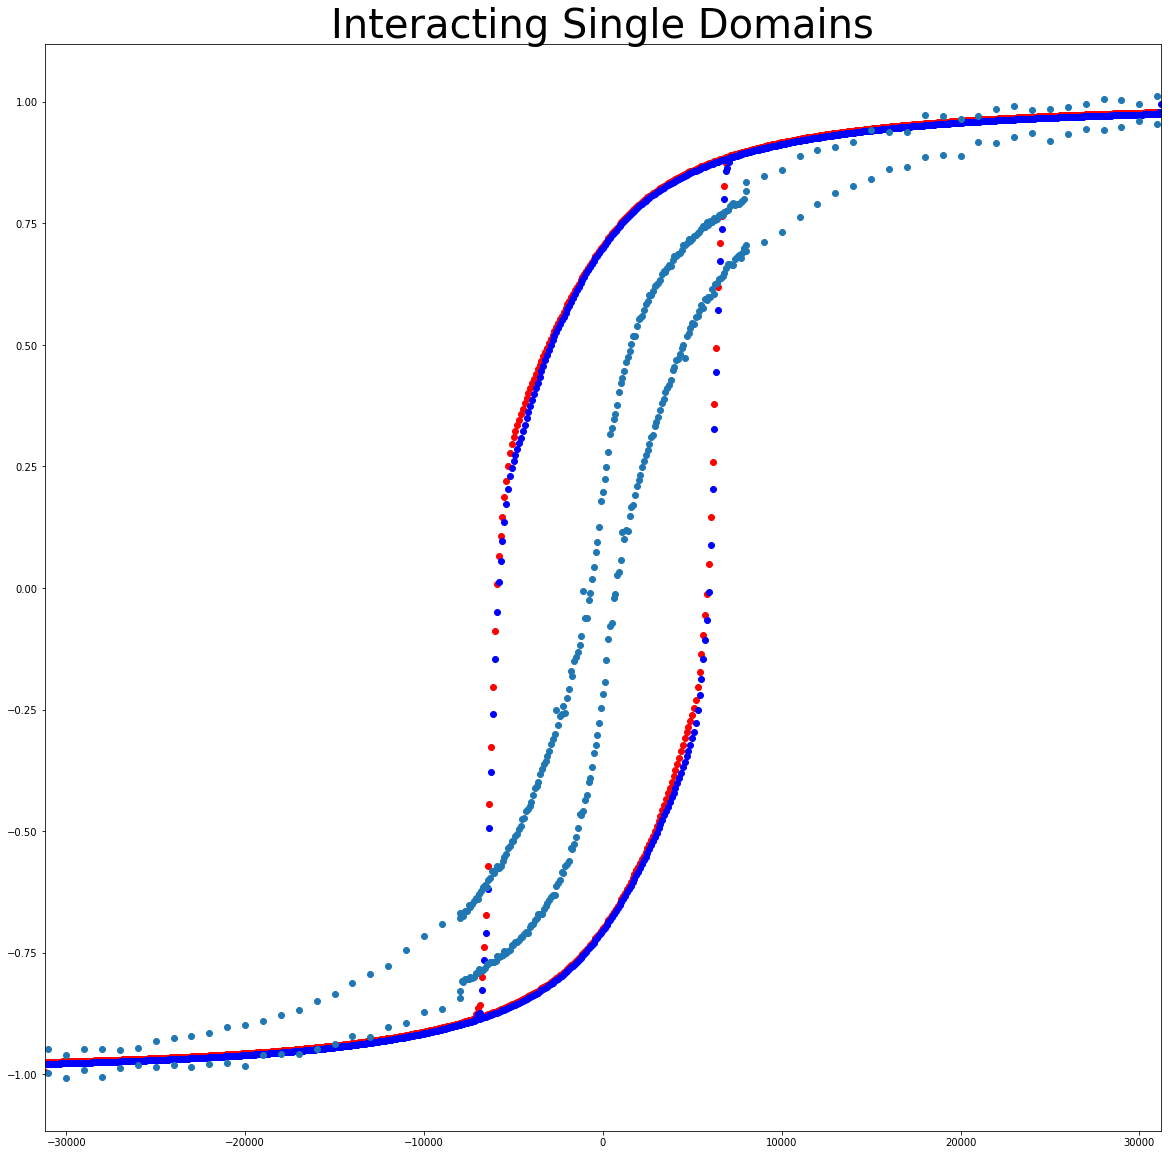

In [72]:
import matplotlib.pyplot as plt

norm=1.00

plt.figure(figsize=(20,20))

plt.title("Interacting Single Domains",size=40)

plt.scatter(h_inter,np.array(m_inter)/norm,color='r')
plt.scatter(-np.array(h_inter),-np.array(m_inter)/norm,color='b')

plt.scatter(hexp_on,mexp_on)

#plt.xlim(-1600*3*3,1600*3*3)
plt.xlim(-abs(hini),abs(hini))

#plt.savefig('firstsimul_20x20_interdipol_3D.jpeg')
#plt.savefig('firstsimul_20x20_nointer_3D.jpeg')
##plt.savefig('firstsimul_10x10_nointer.jpeg')
#plt.savefig('firstsimul_12x12_nointer_3D.jpeg')
#plt.savefig('firstsimul_12x12_interdipol_3D.jpeg')





In [69]:
# experimental data
path='/home/vagner/Desktop/galfenol/gal90deg.txt'
#path='/home/vagner/Desktop/galfenol/gal50deg.txt'
#path = '/home/vagner/Desktop/galfenol/gal0deg.txt'

hexp10ktube = open(path,'r')
hexp=hexp10ktube.readlines()

print(hexp[0])
#print(a1[0][1])

hexp_on=[]
mexp_on=[]
hexp10ktube.close()
for i in range(len(hexp)):
    listexp=hexp[i].split('\t')
    hexp_on.append(float(listexp[0]))
    mexp_on.append(float(listexp[1].split('\n')[0]))

9999.71436	1



In [71]:
path = '/home/vagner/Desktop/RolledupNanomembranes/python3/data_tube_10K_perptubeaxis_h.dat'
#path = '/home/vagner/Desktop/RolledupNanomembranes/python3/data_tube_10K_alongtubeaxis_h.dat'

hexp10ktube = open(path,'r')
hexp=hexp10ktube.readlines()

print(hexp[0])
#print(a1[0][1])

hexp10ktube.close()

#hexp = [float(i) for i in hexp]


path = '/home/vagner/Desktop/RolledupNanomembranes/python3/data_tube_10K_perptubeaxis_m.dat'
#path = '/home/vagner/Desktop/RolledupNanomembranes/python3/data_tube_10K_alongtubeaxis_m.dat'
mexp10ktube = open(path,'r')
mexp=mexp10ktube.readlines()

print(mexp[0])
#print(a1[0][1])

mexp10ktube.close()

#mexp = [float(i)*1.00 for i in mexp]
hexp_on=[]
mexp_on=[]
hexp10ktube.close()
for i in range(1,len(hexp)):
#    listexp=hexp[i].split('\t')
#    hexp_on.append(float(listexp[0]))
#    mexp_on.append(float(listexp[1].split('\n')[0]))
#    print(hexp[i],'e',i)
    hexp_on.append(float(hexp[i]))
    mexp_on.append(float(mexp[i]))    

39999.46094

0.94869



In [1603]:
mexp_on

[0.94869,
 0.96324,
 0.98891,
 0.98755,
 1.00084,
 0.9831,
 1.01205,
 1.00216,
 1.00841,
 1.01188,
 0.99641,
 1.00463,
 1.00521,
 0.99473,
 0.98879,
 0.98507,
 0.98293,
 0.99196,
 0.98503,
 0.97039,
 0.96496,
 0.97101,
 0.97267,
 0.93722,
 0.9382,
 0.94286,
 0.91715,
 0.90765,
 0.90045,
 0.88859,
 0.85924,
 0.84734,
 0.83531,
 0.81655,
 0.79933,
 0.79533,
 0.79431,
 0.79055,
 0.79071,
 0.78877,
 0.79097,
 0.79005,
 0.78647,
 0.77706,
 0.77516,
 0.77395,
 0.76794,
 0.76842,
 0.76649,
 0.75962,
 0.75612,
 0.76204,
 0.75351,
 0.75421,
 0.74624,
 0.75246,
 0.74278,
 0.74435,
 0.73897,
 0.73186,
 0.73018,
 0.72582,
 0.7248,
 0.71883,
 0.7144,
 0.71815,
 0.70972,
 0.70598,
 0.70452,
 0.69584,
 0.68816,
 0.68681,
 0.6836,
 0.68325,
 0.67527,
 0.66193,
 0.66368,
 0.65788,
 0.65092,
 0.65225,
 0.6462,
 0.63396,
 0.62704,
 0.62242,
 0.62143,
 0.61136,
 0.60202,
 0.60205,
 0.58944,
 0.58474,
 0.57137,
 0.55885,
 0.55549,
 0.55305,
 0.53944,
 0.51735,
 0.5183,
 0.50219,
 0.48823,
 0.47415,
 0.465,

In [243]:
stepmag

0.0

In [244]:
coefmag

NameError: name 'coefmag' is not defined